In [114]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [115]:
%cd /content/gdrive/MyDrive/ColabNotebooks/CapstoneBreath

/content/gdrive/MyDrive/ColabNotebooks/CapstoneBreath


In [116]:
!pip install torchaudio soundfile
!pip install torch

# 📄 Описание модели DenoisingAutoencoder

## 🎯 Цель

Удаление шума дыхания из аудиосигнала с сохранением исходной структуры (музыки, речи и т.д.).

---

## 🧠 Архитектура

Модель представляет собой **автоэнкодер** с **опциональным LSTM в bottleneck**, что позволяет учитывать как локальные особенности, так и долгосрочные зависимости. Построена на основе **1D свёрток**, что идеально подходит для аудио во временной области.

---

## 🔷 Компоненты

### Encoder

- `Conv1d(1 → 32)`, `stride=2`, `kernel_size=4`
- `Conv1d(32 → 64)`, `stride=2`, `kernel_size=4`
- `Conv1d(64 → 128)`, `stride=2`, `kernel_size=4`
- Каждое свёртывание уменьшает длину сигнала в 2 раза

### Bottleneck (опционально)

- `2-layer Bidirectional LSTM` со скрытым размером 128
- Линейный слой `Linear(256 → 128)` восстанавливает форму перед декодером

### Decoder

- `ConvTranspose1d(128 → 64)`  
- `ConvTranspose1d(64+64 → 32)` с `skip` из enc2  
- `ConvTranspose1d(32+32 → 1)` с `skip` из enc1  
- Восстанавливает сигнал до исходной длины

---

## 🔁 Схема прохождения

Input [B, 1, T]
 → Encoder (Conv1d)         ↓ сжатие по времени
 → LSTM (T/8, 128×2)        ↓ захват контекста
 → Decoder (ConvTranspose) ↑ восстановление сигнала
 → Output [B, 1, T]


In [117]:
import os
from glob import glob
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch.nn.functional as F
import time
from tqdm import tqdm
import torchaudio
import random
import soundfile as sf
import numpy as np
import subprocess
from glob import glob

In [118]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn


class DenoisingAutoencoder(nn.Module):
    def __init__(self, use_lstm=True):
        super().__init__()
        self.use_lstm = use_lstm

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # LSTM bottleneck
        if self.use_lstm:
            self.lstm = nn.LSTM(
                input_size=128,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                bidirectional=True
            )
            self.lstm_linear = nn.Linear(128 * 2, 128)

        # Decoder
        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),  # T/4
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(64 + 64, 32, kernel_size=4, stride=2, padding=1),  # T/2
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(32 + 32, 1, kernel_size=4, stride=2, padding=1)   # T
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        # Bottleneck
        if self.use_lstm:
            lstm_input = enc3.permute(0, 2, 1)
            lstm_out, _ = self.lstm(lstm_input)
            encoded = self.lstm_linear(lstm_out)
            encoded = encoded.permute(0, 2, 1)
        else:
            encoded = enc3

        # Decoder with skip connections
        dec3 = self.dec3(encoded)
        dec2 = self.dec2(torch.cat([dec3, enc2], dim=1))
        dec1 = self.dec1(torch.cat([dec2, enc1], dim=1))

        return dec1

# 🎼 Описание датасета MusicBreathingDataset

## 🎯 Цель

Создание синтетического обучающего датасета для задачи **очистки аудиотреков от дыхательного шума**. Каждый элемент датасета представляет собой:

- **микшированный аудиосигнал** = музыка + дыхание
- **чистую музыку** (таргет)
- **маску шума** (области, где присутствует дыхание)

---

## 📁 Структура данных

Датасет собирается на лету из двух папок:

- `music_dir` — содержит чистые музыкальные треки (формат `.wav`)
- `noise_dir` — содержит шумы дыхания (тоже `.wav`)

Каждый элемент (`__getitem__`) формируется случайным образом из одного музыкального и одного шумового файла.

---

## 🔧 Этапы генерации одного примера

1. **Загрузка и ресемплинг**:
   - оба сигнала приводятся к моно (усреднение каналов)
   - все аудио приводятся к `sample_rate = 16000`

2. **Обрезка/повтор**:
   - каждый сигнал подгоняется под фиксированную длину (например, 4 секунды)

3. **Микширование с контролем громкости**:
   - дыхание масштабируется под случайный `SNR` в диапазоне `[0, 20] дБ`
   - итоговый сигнал `mixture = music + noise`

4. **Генерация маски дыхания**:
   - на основе `RMS` и `Zero Crossing Rate` (ZCR)
   - если `RMS > 0.005` и `ZCR > 0.05`, считается, что в этом фрейме есть шум

---

## 📐 Маска

Маска генерируется по фреймам:
- `frame_size = 25 мс`
- `hop_size = 10 мс`

Критерии:
- **RMS** — энергия дыхания
- **ZCR** — количество смен знака (помогает отличить шум от тона)

Итоговая маска — бинарный вектор, соответствующий временной оси сигнала. Используется для **маскированного обучения**.

---

## 📌 Выход датасета

```python
mixture : Tensor [1, T]  # зашумленный сигнал (вход модели)
music   : Tensor [1, T]  # оригинальный трек (таргет)
mask    : Tensor [F]     # маска шума (0 — тишина, 1 — шум дыхания)


In [120]:
import os
from glob import glob

def sliding_rms(waveform, frame_size, hop_size):
    waveform_sq = waveform ** 2
    window = torch.ones(1, 1, frame_size)
    return torch.sqrt(F.conv1d(waveform_sq.unsqueeze(0), window, stride=hop_size) / frame_size).squeeze()

def zero_crossing_rate(waveform, frame_size, hop_size):
    waveform = waveform[0]  # [T]
    sign_changes = torch.diff(torch.sign(waveform)).abs().unsqueeze(0).unsqueeze(0)
    window = torch.ones(1, 1, frame_size)
    return F.conv1d(sign_changes, window, stride=hop_size).squeeze() / frame_size

class MusicBreathingDataset(torch.utils.data.Dataset):
    def __init__(self, music_dir, noise_dir, segment_seconds=4.0, sample_rate=16000, snr_range=(0, 20)):
        self.music_files = [os.path.join(music_dir, f) for f in os.listdir(music_dir) if f.endswith(".wav")]
        self.noise_files = [os.path.join(noise_dir, f) for f in os.listdir(noise_dir) if f.endswith(".wav")]
        self.segment_samples = int(segment_seconds * sample_rate)
        self.sample_rate = sample_rate
        self.snr_range = snr_range

    def __len__(self):
        return 1250  # Arbitrary large number for infinite sampling

    def __getitem__(self, idx):
        music_path = random.choice(self.music_files)
        noise_path = random.choice(self.noise_files)

        music, sr = torchaudio.load(music_path)
        noise, sr_n = torchaudio.load(noise_path)

        if sr != self.sample_rate:
            music = torchaudio.functional.resample(music, sr, self.sample_rate)
        if sr_n != self.sample_rate:
            noise = torchaudio.functional.resample(noise, sr_n, self.sample_rate)

        music = torch.mean(music, dim=0, keepdim=True)
        noise = torch.mean(noise, dim=0, keepdim=True)

        if music.shape[1] < self.segment_samples:
            repeat = self.segment_samples // music.shape[1] + 1
            music = music.repeat(1, repeat)[:, :self.segment_samples]
        if noise.shape[1] < self.segment_samples:
            repeat = self.segment_samples // noise.shape[1] + 1
            noise = noise.repeat(1, repeat)[:, :self.segment_samples]

        start_m = random.randint(0, music.shape[1] - self.segment_samples)
        start_n = random.randint(0, noise.shape[1] - self.segment_samples)

        music = music[:, start_m:start_m + self.segment_samples]
        noise = noise[:, start_n:start_n + self.segment_samples]

        music_rms = music.pow(2).mean().sqrt()
        noise_rms = noise.pow(2).mean().sqrt().clamp(min=1e-6)

        snr_db = random.uniform(*self.snr_range)
        target_rms = music_rms / (10 ** (snr_db / 20))
        scale = target_rms / noise_rms
        noise = noise * scale

        mixture = (music + noise).clamp(-1.0, 1.0)

        frame_size = int(0.025 * self.sample_rate)
        hop_size = int(0.010 * self.sample_rate)

        rms = sliding_rms(noise, frame_size, hop_size)
        zcr = zero_crossing_rate(noise, frame_size, hop_size)

        mask = ((rms > 0.005) & (zcr > 0.05)).float()
        return mixture, music, mask


# 🎯 Описание функции потерь BreathAwareLoss

## 📌 Назначение

Функция потерь `BreathAwareLoss` предназначена для обучения модели аудиоденоизинга с учётом **локализации шума дыхания**. Она объединяет два вида ошибок:

- **Базовая ошибка (`base_loss`)** — L1-разница между предсказанным и чистым аудиосигналом на всём участке.
- **Маскированная ошибка (`mask_loss`)** — L1-разница, вычисляемая **только по фреймам**, где по маске присутствует шум дыхания.

---

## ⚙️ Формула

Итоговая функция потерь:

total_loss = base_weight * L1(pred, target) + mask_weight * L1(pred * mask, target * mask)

где:
- `base_weight` — вес ошибки по всему сигналу (по умолчанию 5)
- `mask_weight` — вес ошибки только на шумовых участках (по умолчанию 10)

---

## 📐 Компоненты

- `safe_upsample(mask, target_len)` — увеличивает разрешение маски по времени, чтобы оно совпадало с аудиосигналом.
- `F.l1_loss(...)` — стандартная L1 ошибка от PyTorch.
- `mask` — бинарная маска [0, 1], где `1` указывает на наличие дыхательного шума.

---

## 💡 Особенности

- Маска применяется **мягко**, без обнуления несигнальных фреймов — она просто фокусирует loss на ключевых зонах.
- Подходит для задач, где шум **локализован во времени**, и важно обучить модель различать "где чисто, а где грязно".

---

## 🧪 Пример использования

```python
criterion = BreathAwareLoss(base_weight=5, mask_weight=10)
loss = criterion(pred_wave, clean_wave, mask)


In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

class BreathAwareLoss(nn.Module):
    def __init__(self, base_weight=1, mask_weight=10):
        super().__init__()
        self.base_weight = base_weight
        self.mask_weight = mask_weight

    def safe_upsample(self, mask, target_len):
        factor = target_len // mask.shape[-1]
        upsampled = mask.repeat_interleave(factor, dim=1)
        if upsampled.shape[-1] < target_len:
            pad = target_len - upsampled.shape[-1]
            upsampled = F.pad(upsampled, (0, pad))
        return upsampled[:, None, :]  # [B, 1, T]

    def forward(self, pred_wave, target_wave, mask):
        B, _, T = pred_wave.shape

        mask_upsampled = self.safe_upsample(mask, T)  # [B, 1, T]


        base_loss = F.l1_loss(pred_wave, target_wave)
        mask_loss = F.l1_loss(pred_wave * mask_upsampled, target_wave * mask_upsampled)

        total = (
            self.base_weight * base_loss +
            self.mask_weight * mask_loss
        )
        return total



def train_model(model, train_loader, epochs=10, lr=1e-3, device='cuda', checkpoint_path="checkpoints/dac.pt"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = BreathAwareLoss()
    l1_loss = nn.L1Loss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for mixture, music, mask in pbar:
            mixture = mixture.to(device)
            music = music.to(device)
            mask = mask.to(device)

            pred = model(mixture)

            min_len = min(pred.shape[-1], music.shape[-1])
            pred = pred[..., :min_len]
            music = music[..., :min_len]
            mixture = mixture[..., :min_len]

            loss = criterion(pred, music, mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({"loss": loss.item()})

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Avg Train Loss: {avg_train_loss:.4f}")

        ckpt = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch + 1
        }
        torch.save(ckpt, checkpoint_path)

In [122]:
music_dir = "musdb18/train"
noise_dir = "noises/augmented"
batch_size=32,
segment_seconds = 4.0
sample_rate = 16000
snr_range = (0, 10)
epochs = 30
# epochs = 200
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataset = MusicBreathingDataset(
    music_dir=music_dir,
    noise_dir=noise_dir,
    segment_seconds=segment_seconds,
    sample_rate=sample_rate,
    snr_range=snr_range
)
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

# 2. Модель
model = DenoisingAutoencoder()
# 3. Тренировка
train_model(model, train_loader, epochs=epochs, lr=lr, checkpoint_path="checkpoints/dac.pth")

Epoch 1/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.96it/s, loss=0.53]


Epoch 1/30, Avg Train Loss: 0.8865


Epoch 2/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.97it/s, loss=0.271]


Epoch 2/30, Avg Train Loss: 0.3441


Epoch 3/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.98it/s, loss=0.211]


Epoch 3/30, Avg Train Loss: 0.3208


Epoch 4/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.94it/s, loss=0.171]


Epoch 4/30, Avg Train Loss: 0.3085


Epoch 5/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.00it/s, loss=0.16]


Epoch 5/30, Avg Train Loss: 0.3073


Epoch 6/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.01it/s, loss=0.267]


Epoch 6/30, Avg Train Loss: 0.3053


Epoch 7/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s, loss=0.491]


Epoch 7/30, Avg Train Loss: 0.3064


Epoch 8/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.02it/s, loss=0.0581]


Epoch 8/30, Avg Train Loss: 0.2977


Epoch 9/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.00it/s, loss=0.144]


Epoch 9/30, Avg Train Loss: 0.2853


Epoch 10/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s, loss=0.446]


Epoch 10/30, Avg Train Loss: 0.2975


Epoch 11/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.02it/s, loss=0.364]


Epoch 11/30, Avg Train Loss: 0.2910


Epoch 12/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.00it/s, loss=0.264]


Epoch 12/30, Avg Train Loss: 0.2869


Epoch 13/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s, loss=0.197]


Epoch 13/30, Avg Train Loss: 0.2867


Epoch 14/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s, loss=0.297]


Epoch 14/30, Avg Train Loss: 0.2878


Epoch 15/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.02it/s, loss=0.141]


Epoch 15/30, Avg Train Loss: 0.2786


Epoch 16/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.01it/s, loss=0.335]


Epoch 16/30, Avg Train Loss: 0.2849


Epoch 17/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.97it/s, loss=0.341]


Epoch 17/30, Avg Train Loss: 0.2808


Epoch 18/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.97it/s, loss=0.328]


Epoch 18/30, Avg Train Loss: 0.2796


Epoch 19/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s, loss=0.146]


Epoch 19/30, Avg Train Loss: 0.2798


Epoch 20/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.00it/s, loss=0.316]


Epoch 20/30, Avg Train Loss: 0.2785


Epoch 21/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.00it/s, loss=0.414]


Epoch 21/30, Avg Train Loss: 0.2798


Epoch 22/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.00it/s, loss=0.201]


Epoch 22/30, Avg Train Loss: 0.2774


Epoch 23/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.97it/s, loss=0.242]


Epoch 23/30, Avg Train Loss: 0.2763


Epoch 24/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.97it/s, loss=0.184]


Epoch 24/30, Avg Train Loss: 0.2747


Epoch 25/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s, loss=0.217]


Epoch 25/30, Avg Train Loss: 0.2711


Epoch 26/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.92it/s, loss=0.222]


Epoch 26/30, Avg Train Loss: 0.2735


Epoch 27/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  5.00it/s, loss=0.419]


Epoch 27/30, Avg Train Loss: 0.2699


Epoch 28/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.95it/s, loss=0.216]


Epoch 28/30, Avg Train Loss: 0.2803


Epoch 29/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s, loss=0.141]


Epoch 29/30, Avg Train Loss: 0.2714


Epoch 30/30 [Train]: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s, loss=0.192]

Epoch 30/30, Avg Train Loss: 0.2756


In [123]:
@torch.no_grad()
def validate_model(model, val_loader, criterion, device='cuda'):
    model.eval()
    total_val_loss = 0.0
    pbar = tqdm(val_loader, desc="[Validation]")
    for mixture, music, mask in pbar:
        mixture = mixture.to(device)
        music = music.to(device)
        mask = mask.to(device)

        pred = model(mixture)

        min_len = min(pred.shape[-1], music.shape[-1])
        pred = pred[..., :min_len]
        music = music[..., :min_len]
        mask = mask[..., :min_len]

        loss = criterion(pred, music, mask)
        total_val_loss += loss.item()
        pbar.set_postfix({"val_loss": loss.item()})

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Avg Validation Loss: {avg_val_loss:.4f}")

val_dataset = MusicBreathingDataset(
    music_dir="musdb18/test",
    noise_dir="noises/test",
    segment_seconds=segment_seconds,
    sample_rate=sample_rate,
    snr_range=snr_range
)
val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

validate_model(model, val_loader, BreathAwareLoss(), device)

[Validation]: 100%|██████████| 157/157 [00:26<00:00,  5.94it/s, val_loss=0.351]

Avg Validation Loss: 0.3339


In [127]:
def predict_and_play(model, mixture_path, clean_path=None, sample_rate=16000, device="cuda"):
    model.eval()
    model = model.to(device)

    # Загрузка и ресемплирование
    mixture, sr_m = torchaudio.load(mixture_path)
    if sr_m != sample_rate:
        mixture = torchaudio.functional.resample(mixture, sr_m, sample_rate)
    mixture = torch.mean(mixture, dim=0, keepdim=True)  # [1, T]

    # Ограничим 10 секундами
    max_samples = sample_rate * 12
    mixture = mixture[:, :max_samples]
    total_samples = mixture.shape[1]

    SEGMENT_SAMPLES = sample_rate * 4
    predicted_segments = []

    # Обработка 4-секундных окон
    with torch.no_grad():
        for start in range(0, total_samples, SEGMENT_SAMPLES):
            end = start + SEGMENT_SAMPLES
            segment = mixture[:, start:end]
            if segment.shape[-1] < SEGMENT_SAMPLES:
                pad_len = SEGMENT_SAMPLES - segment.shape[-1]
                segment = F.pad(segment, (0, pad_len))

            input_tensor = segment.unsqueeze(0).to(device)
            pred_segment = model(input_tensor)
            pred_segment = pred_segment.squeeze().cpu().clamp(-1, 1)
            predicted_segments.append(pred_segment[:segment.shape[-1]])

    pred_music = torch.cat(predicted_segments, dim=-1)

    # Визуализация
    fig, axs = plt.subplots(3 if clean_path else 2, 1, figsize=(12, 6), sharex=True)
    t = torch.linspace(0, mixture.shape[1] / sample_rate, mixture.shape[1])
    axs[0].plot(t, mixture.squeeze(), label="Noisy mixture")
    axs[0].set_title("Noisy Mixture")
    axs[1].plot(t[:pred_music.shape[-1]], pred_music, label="Predicted Music", color="green")
    axs[1].set_title("Predicted Clean Music")

    if clean_path:
        clean, sr_c = torchaudio.load(clean_path)
        if sr_c != sample_rate:
            clean = torchaudio.functional.resample(clean, sr_c, sample_rate)
        clean = torch.mean(clean, dim=0)
        clean = clean[:pred_music.shape[-1]]
        axs[2].plot(t[:clean.shape[0]], clean, label="Ground Truth", color="orange")
        axs[2].set_title("Ground Truth Clean Music")

    for ax in axs:
        ax.grid()
    plt.tight_layout()
    plt.show()

    print("\n▶️ Mixture")
    display(Audio(mixture.squeeze().numpy(), rate=sample_rate))
    print("\n🧹 Predicted Clean Music")
    display(Audio(pred_music.numpy(), rate=sample_rate))
    if clean_path:
        print("\n🎧 Ground Truth Clean Music")
        display(Audio(clean.numpy(), rate=sample_rate))



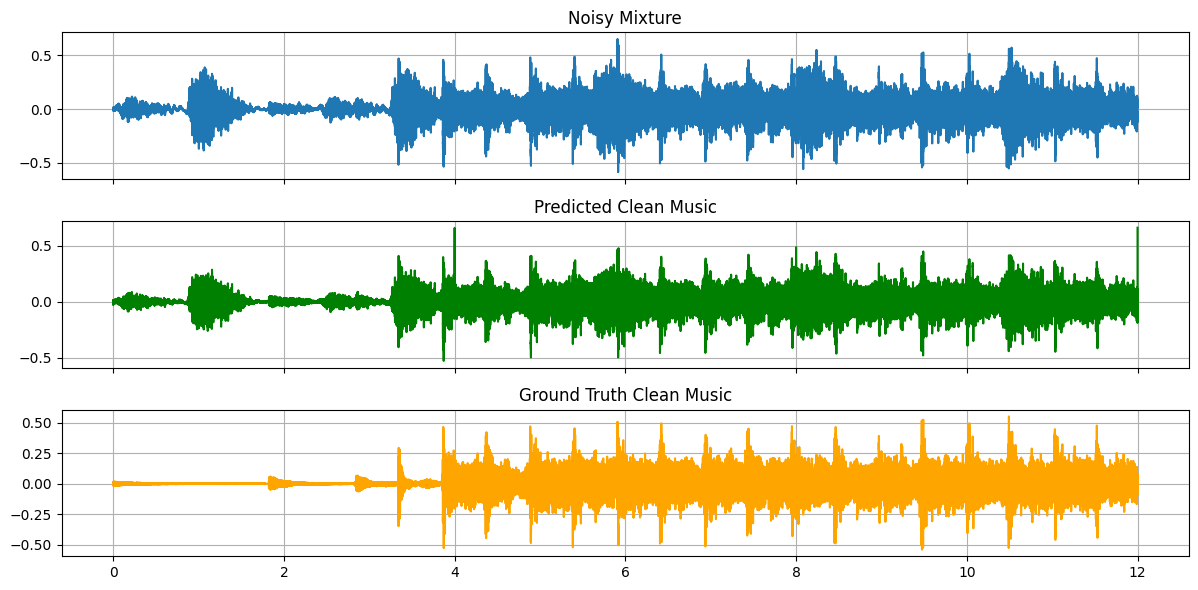


▶️ Mixture



🧹 Predicted Clean Music



🎧 Ground Truth Clean Music


In [128]:
model = DenoisingAutoencoder()
model.load_state_dict(torch.load("checkpoints/dac.pth")['model_state_dict'])
model = model.to(DEVICE)

noisy_path = "musdb_noisy/test/Zeno - Signs_3.wav"
clean_path = "musdb18/test/Zeno - Signs.wav"

predict_and_play(model, mixture_path=noisy_path, clean_path=clean_path, sample_rate=16000, device=device)


Волны шума немного уменьшились но их отчётливо слышно

## 🧩 Вывод: Плато в обучении и сложность музыкального сигнала

Обучение модели стабильно выходит на **плато** — `mask_loss` перестаёт снижаться, и заметный остаточный шум сохраняется даже после многих эпох. Это указывает на то, что модель достигла **предела своей способности обобщать**, либо сталкивается с **избыточной сложностью задачи**.

Музыкальный сигнал — это **многосоставной объект**, в котором сочетаются:
- вокал,
- ударные,
- бас,
- фоновые инструменты и эффекты.

Удаление шума из такой смеси требует от модели различать и сохранять **разные акустические элементы**, не имея явного разделения по ролям.

---

## 🧠 Что можно сделать

Согласно проверенным наработкам в области **музыкальной сепарации**, более эффективный подход:
1. **Сначала разделить музыку на отдельные компоненты** (vocal, drums, bass, etc.)
   - Например, с помощью моделей типа `Spleeter` или `Demucs` либо самописный вариант например Unet похожи на этот
2. **При необходимости очищать нужную дорожку** (обычно вокал) с помощью автоэнкодера или другой denoising-модели
3. **И, наконец, объединять очищенные треки обратно в финальный микс**

---

## ✅ Преимущества такого подхода

- Модель работает только с **одним типом источника**, например, вокалом → проще выделять шум
- Можно применять разные стратегии очистки к разным инструментам
- Исключается риск "перечистки", когда модель искажает важные музыкальные детали

---

Таким образом, разделение и поэтапная очистка позволяют значительно лучше контролировать качество и избегать компромиссов, связанных с обработкой сложного многоголосого сигнала.
